# Running taup with ObsPy

We are going to need to predict travel times for different seismic 
phases and various Earth models. We can do this using the `obspy.taup`
module. ObsPy "is an open-source project dedicated to provide a Python 
framework for processing seismological data" which is presented as a
Python _package_. This notebook covers installation of ObsPy and a 
brief overview of `obspy.taup`, which (as of version 0.10.1) is a 
reimplementation of the Java TauP toolkit in Python (and C). Documentation
for `obspy.taup` is at http://docs.obspy.org/packages/obspy.taup.html and
the Java implementation (with includes an outline of the methods used)
can be found at http://www.seis.sc.edu/taup/.

## Installation

Assuming you are running Anaconda, ObsPy (including taup) can
be installed with:

    conda install -c obspy obspy
    
from the shell. No other modules are needed to run this 
notebook.

## From an Earth model to travel times 

We first need to import taup, then create an Earth 
model.

In [1]:
# Get access to taup
import obspy.taup

# Create the Earth model
# iasp91 is built in and 
# distributed with the code
earth_model = obspy.taup.TauPyModel(model="iasp91")

We can now use `earth_model` to calculate travel times. 
The first argument to `get_travel_times` is the source
depth (in km), the second is the epicentral distance 
(in degrees). The list of phases is optional, but it 
keeps the list of arrivals to a reasonable length. Notice
how printing the arrivals gives formatted data.

In [2]:
arrivals = earth_model.get_travel_times(150, 80, phase_list=['PcP','P'])
print arrivals

2 arrivals
	P phase arrival at 712.600 seconds
	PcP phase arrival at 719.326 seconds


Our variable `arrivals` is an object containing a list of
`Arrival` objects. If we want to access the travel time 
directly (e.g. to calculate the PcP-P differential travel 
time) we need to make use of the `.time` attribute.

In [3]:
PcP_P_time = arrivals[1].time - arrivals[0].time
print 'PcP-P differential travel time is {: f} s'.format(PcP_P_time)

PcP-P differential travel time is  6.725255 s


## Other methods

It is also possible to calculate ray paths and
pierce points using the `get_ray_paths` and 
`get_pierce_points` methods. These take 
the same arguments as `get_travel_times` but
return more data which lives in numpy arrays.

In [4]:
arrivals = earth_model.get_ray_paths(150, 80, phase_list=['PcP','P'])
print arrivals
print type(arrivals[0].path) # This data is too large to print

2 arrivals
	P phase arrival at 712.600 seconds
	PcP phase arrival at 719.326 seconds
<type 'numpy.ndarray'>


In [5]:
arrivals = earth_model.get_pierce_points(150, 80, phase_list=['PcP','P'])
print arrivals
arrivals[1].pierce # This is more reasonable

2 arrivals
	P phase arrival at 712.600 seconds
	PcP phase arrival at 719.326 seconds


array([(250.00555286477655, 0.0, 0.0, 150.0),
       (250.00555286477655, 7.741079100307414, 0.0034090693794839354, 210.0),
       (250.00555286477655, 32.47078185831517, 0.01605128821065949, 410.0),
       (250.00555286477655, 60.644584065172566, 0.03585242346969637, 660.0),
       (250.00555286477655, 349.16348061226375, 0.694347662072777, 2889.0),
       (250.00555286477655, 637.6823771593549, 1.3528429006758576, 660.0),
       (250.00555286477655, 665.8561793662124, 1.3726440359348944, 410.0),
       (250.00555286477655, 690.5858821242201, 1.3852862547660698, 210.0),
       (250.00555286477655, 698.3269612245275, 1.3886953241455537, 150.0),
       (250.00555286477655, 713.3968395736758, 1.3949006196472409, 35.0),
       (250.00555286477655, 715.7841965599254, 1.395527286353555, 20.0),
       (250.00555286477655, 719.3257168643476, 1.3962634015954634, 0.0)], 
      dtype=[('p', '<f8'), ('time', '<f8'), ('dist', '<f8'), ('depth', '<f8')])

These methods can be used for plotting. We first need to tell ipython to plot inside the notebook.

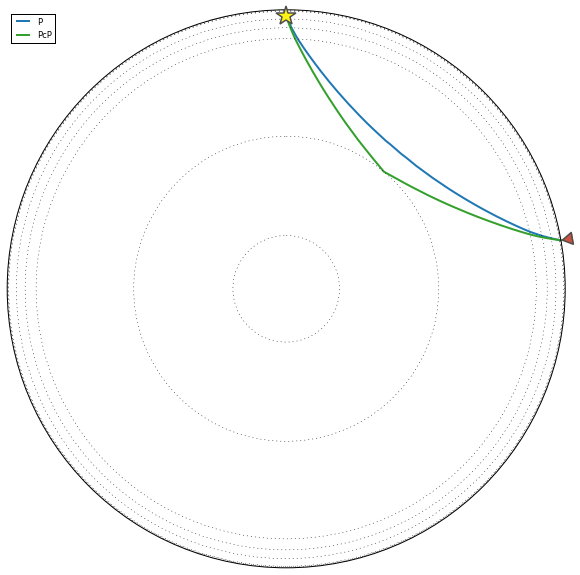

In [6]:
%matplotlib inline  
arrivals = earth_model.get_ray_paths(150, 80, phase_list=['PcP','P'])
arrivals.plot()  

## Performance

If we want to use this a lot, it will be useful to know how 
fast it goes. Creating a new model instance is supposed to 
be quite slow, but the core loops are in C. If we are only
interested in a few phases, it is worth saying so.

In [7]:
%%timeit
arrivals = earth_model.get_travel_times(150, 80, phase_list=['PcP','P'])

100 loops, best of 3: 4.97 ms per loop


In [8]:
%%timeit
arrivals = earth_model.get_travel_times(150, 80)

10 loops, best of 3: 33.2 ms per loop


## Raypaths for tomographic correction
A useful module for this is geographiclib (which is suprisingly new) and
has a python implementation. It's very OO, but that should not be an issue.

This is not in anaconda, but `pip install geographiclib` works for me.

In [9]:
import numpy as np
import geographiclib.geodesic as geod


In [10]:
# Let's imagine an event at:
eLat = 40.6
eLon = -73.8
edepth = 150 # km

# Let's sa
rLat = 50.2
rLon = 10.4

# Find the geodesic, azimuth and angular distance (which we should check)
g = geod.Geodesic.WGS84.Inverse(eLat, eLon, rLat, rLon)
epi_dist = g['a12']
azi = g['azi1']

print epi_dist
print azi

56.8610947805
49.6576833148


In [11]:
# Now find the raypath in the "normal" way, and produce the 
# results we need for tomocor from the geodesic

arrivals = earth_model.get_ray_paths(edepth, epi_dist, phase_list=['PcP'])
line = geod.Geodesic.WGS84.Line(eLat, eLon, azi)

dists = []
lats = []
lons = []
depths = []

# And for each point on the path, work out the lat and lon
# and produce the results
for dist, depth in zip(np.degrees(arrivals[0].path['dist']), 
                       arrivals[0].path['depth']):
    pos = line.ArcPosition(dist)
    lats.append(pos['lat2'])
    lons.append(pos['lon2'])
    dists.append(dist)
    depths.append(depth)

In [12]:
# Turn the result into something we may be able to work with...
print zip(lats, lons, dists, depths)

[(40.6, -73.8, 0.0, 150.0), (40.62307304724378, -73.76433845754217, 0.035632189244963981, 162.53361676434173), (40.62535278933707, -73.76081263942764, 0.039153771381268285, 163.76629142699881), (40.627636334149194, -73.75728053137958, 0.042681395328434991, 165.0), (40.65138838639576, -73.72051739882093, 0.079383567100486135, 177.77209396024708), (40.67555458388248, -73.68306770227076, 0.11674437671696936, 190.65552832769848), (40.71223410574425, -73.62613836488548, 0.17348687163404225, 210.0), (40.71922147700474, -73.61528137288266, 0.18430115379994316, 213.65604638359716), (40.72625152116542, -73.60435416856916, 0.19518308478430071, 217.32386793142973), (40.748745452022824, -73.56936418258326, 0.23001267175468953, 228.9894273773171), (40.7716801643288, -73.53364709623703, 0.26554179224439994, 240.77490524387142), (40.809548431620925, -73.47458152496284, 0.32424287053255191, 260.0), (40.813912548837216, -73.46776715585133, 0.33101089017920032, 262.19715768126889), (40.81829242475691, -